# Machine Learning Demonstrations

In this notebook, we showcase how to use kdb+/q Natural Language Processing library.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

Besides those installed via the requirements.txt file, there is also a requirement that the English model be downloaded for Spacy:

`$ python -m spacy download en`

## Natural Language Processing

Natural language processing (NLP) can be used to answer a variety of questions about unstructured text data, as well as facilitating open-ended exploration. It can be applied to datasets containing emails, online articles, comments, tweets, novels, etc.

Although the source is text, transformations are applied to convert this data to vectors, dictionaries and symbols which can be handled very effectively by q. Many operations such as searching, clustering and keyword extraction can all be done using very simple data structures, such as feature vectors.

The kdb+/q NLP library can be loaded using the below syntax.

In [1]:
\l nlp/nlp.q
\l nlp/init.q

## Preparing text

In NLP, a collection of documents is called a corpus, with the plural being corpora.

Text often comes with associated metadata. For e-mails, this could be the sender/receivers, date sent or labels applied. For online comments, this could include a username, rating or URL. As these are often relevant to the analysis, it is convenient to store the plain text and metadata together in a table, with a row for every document.

Once the plain text has been retrieved, operations common to many higher-level NLP operations can be done. Operations include:
- **Tokenization**: splits input into words or similar tokens, e.g. John’s > John and ‘s as separate tokens.
- **Sentence detection**: gives indices at which sentences start and end.
- **Part of speech tagger**: parses sentences into tokens and gives each token a label, e.g. lemma, pos, tag, etc. (Penn Treebank and Universal tags are both supported: http://universaldependencies.org/u/pos/).
- **Lemmatization**: normalizes words to their base form, e.g. "ran" to "run".
- **Sentiment analysis**: scores sentences for their negative, positive and neutral sentiment using a prebuilt model with degrees of positive/negative sentiment for English words and emoticons, as well as parsing to account for negation, adverbs and other modifiers.

## Sections

This notebook is split into 3 distinct sections which cover different use cases for NLP algorithm.
1. [Moby Dick](#Moby-Dick)
2. [The Enron Email Dataset](#Enron)
3. [VAST Challenge 2014](#VAST)

In [2]:
/ load graphics functions used throughout
\l ../utils/graphics.q

---

<a id='Moby-Dick'></a>
# Moby Dick

In this section we analyze the text of Moby-Dick, which can be downloaded from the [Project Gutenberg](https://www.gutenberg.org/files/2701/2701-h/2701-h.htm) website.

*"Moby-Dick; or, The Whale is an 1851 novel by American writer Herman Melville. The book is sailor Ishmael's narrative of the obsessive quest of Ahab, captain of the whaling ship Pequod, for revenge on Moby Dick, the white whale that on the ship's previous voyage bit off Ahab's leg at the knee."* https://en.wikipedia.org/wiki/Moby-Dick. 

### Load data

Below we read in data from `mobydick.txt`, mentioned above, and get rid of any bad new lines in the file.

In [3]:
/ read in data
text:"\n"sv read0`:../data/mobydick.txt
removeBadNewlines:{@[x;1+(raze string x="\n")ss"010";:;" "]}
mobyDick:(text ss "CHAPTER ")cut removeBadNewlines text

### Parse data

The following options are available for the function `.nlp.newParser`:

field       | content
------------|------------------------------------------------------------------
`text       | The original word text, returns a list of characters.
`tokens     | The tokenized text, returns a list of symbols.
`sentChars  | Indices of start and end of sentences, returns a list of lists of longs.
`sentIndices| Indices of the first token of each sentences, returns a list of integers.
`pennPOS    | The Penn Treebank tagset, returns a list of symbols.
`uniPOS     | The Universal tagset, returns a list of symbols.
`lemmas     | The base form of the word, returns a list of symbols.
`isStop     | Is the token part of the stop list? Returns a boolean.
`likeEmail  | Does the token resembles an email? Returns a boolean.
`likeURL    | Does the token resembles a URL? Returns a boolean.
`likeNumber | Does the token resembles a number? Returns a boolean.
`keywords   | The significance of each term, returns a list of dictionaries.
`starts     | Index that a token starts at, returns a long.

An example of how to create a parsed table is shown below.

In [4]:
myparser:.nlp.newParser[`en;`text`tokens`lemmas`pennPOS`isStop`sentChars`starts`sentIndices`keywords] 
corpus:myparser mobyDick
-1 corpus[0]`text;

CHAPTER 1

  Loomings



Call me Ishmael.  Some years ago--never mind how long precisely-- having little or no money in my purse, and nothing particular to interest me on shore, I thought I would sail about a little and see the watery part of the world.  It is a way I have of driving off the spleen and regulating the circulation. Whenever I find myself growing grim about the mouth; whenever it is a damp, drizzly November in my soul; whenever I find myself involuntarily pausing before coffin warehouses, and bringing up the rear of every funeral I meet; and especially whenever my hypos get such an upper hand of me, that it requires a strong moral principle to prevent me from deliberately stepping into the street, and methodically knocking people's hats off--then, I account it high time to get to sea as soon as I can.  This is my substitute for pistol and ball. With a philosophical flourish Cato throws himself upon his sword; I quietly take to the ship.  There is nothing surprising in thi

### Exploratory analysis

We want to find all proper nouns in the first chapter using `.nlp.findPOSRuns` which finds runs of consecutive tokens whose part of speech is in the set passed in. We only want to take the first value of each pair in order to omit the token's position.

In [5]:
.nlp.findPOSRuns[`pennPOS;`NNP`NNPS;corpus 0][;0]

`ishmael`precisely--`november`cato`manhattoes`mole`sabbath`corlears hook`coen..


### Feature vectors

Feature vectors are dictionaries of terms and their associated weights. The values associated with each term in a feature vector are how significant that term is as a descriptor of the entity. The significance of the word is calculated by comparing the frequency of the word in that document compared to the rest of the corpus.

As this is a book, we treat this dataset as a single document other than a collection of documents, we use the `.nlp.keywordsContinuous` function to find the most significant words.

In [6]:
show 10#keywords:.nlp.keywordsContinuous corpus

ahab     | 64.24599
peleg    | 52.35585
bildad   | 46.85642
whale    | 42.44738
stubb    | 37.84587
queequeg | 35.49239
steelkilt| 33.94739
pip      | 32.89411
thou     | 31.87325
starbuck | 31.64438


We can see the terms that occur the most are the names of the three captians on a boat and _"whale"_.

Below we plot the occurrences per chapter of the top 10 keywords in Moby Dick. This reveals a discontinuity from chapters 32 to 45, which are an aside discussing whale biology.

In [7]:
/ create a table with average occurence of top 10 keywords in each chapter
kwcount:{([]term:x;chapter:til count corpus;occurences:5 mavg sum each x=corpus`tokens)}
show 5#tab:raze kwcount each key 10#keywords

term chapter occurences
-----------------------
ahab 0       0         
ahab 1       0         
ahab 2       0         
ahab 3       0         
ahab 4       0         


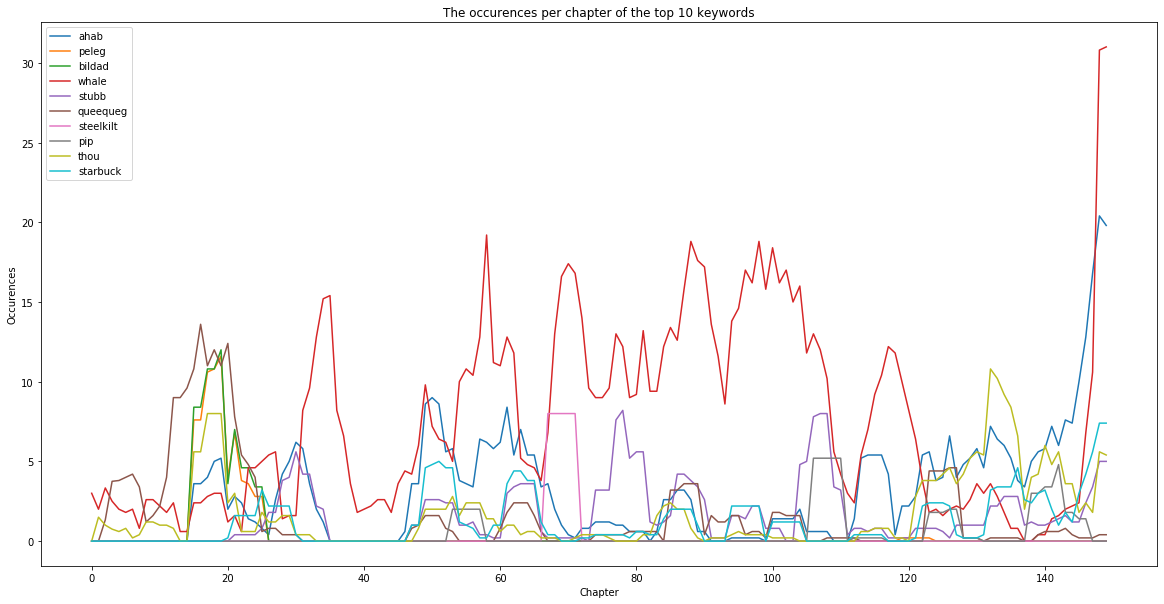

In [8]:
/ plot occurence of top terms per chapter
.util.plt[`:figure][`figsize pykw 20 10];
{a:exec chapter from tab where term=x;
 b:exec occurences from tab where term=x;
 .util.plt[`:plot][a;b];
 }each key 10#keywords; 

.util.plt[`:title]"The occurences per chapter of the top 10 keywords";
.util.plt[`:ylabel]"Occurences";
.util.plt[`:xlabel]"Chapter";
.util.plt[`:legend][key 10#keywords;`loc pykw"upper left"];
.util.plt[`:show][];

### Calculate feature vectors for words

The feature vector for a word can be calculated as a collection of how well other words predict the given keyword. The weight given to these words is a function of how much higher the actual co-occurrence rate is from the expected co-occurrence rate the terms would have if they were randomly distributed.

`.nlp.findRelatedTerms` finds terms that have occured in the same sentence as the queried word. It returns a dictionary of each related term and their z-score in a descending order. A large z-score indicates that the term occured more frequently than if the term was randomly distributed in the corpus.

In [9]:
/ find words relating to captain
5#.nlp.findRelatedTerms[corpus;`captain]

peleg | 1.665086
bildad| 1.336501
ahab  | 1.236744
ship  | 1.154238
cabin | 0.9816231


### Find related phrases

Phrases can be found by looking for runs of words with an above average significance to the query term. 

In [10]:
.nlp.extractPhrases[corpus;`captain]

`captain`ahab      | 49
`captain`peleg     | 23
`captain`bildad    | 10
`stranger`captain  | 6
`captain`sleet     | 5
`sea`captain       | 3
`captain`pollard   | 3
`whaling`captain   | 2
`captain`ahab`stood| 2
`captain`stood     | 2
`captain`d'wolf    | 2
`captain`mayhew    | 2
`way`captain       | 2
`captain`boomer    | 2


We see that _"captain ahab"_ is the phrase releated to captain that occurs the most in this corpus.

---

<a id='Enron'></a>
# The Enron Email Dataset 

The [Enron Email Dataset](https://www.cs.cmu.edu/~enron/) is one of the few, if not the only, large publicly available dataset of corporate emails. Made available after the Enron trial, it includes the emails of many employees, including c-suite individuals such as former Enron CEOs Jeffrey Skilling and Ken Lay, whose emails will be investigated in this paper.

### Load data

Below we create functions to read in the email data. It should be noted that some dates, such as `1979.12.31`, are invalid and will show as `0nd`.

In [11]:
parseEnronEmail:{[email]
 tag:findtag email;
 k:`date`time`subject`from`to`cc`bcc`text;
 v:(rmdate ff .nlp.findDates dt;ff .nlp.findTimes dt:tag"Date"),
   (tag each("Subject";"From";"To";"Cc";"Bcc")),enlist(2+first email ss"\n\n") _ email;
 k!v}

findtag:{
 newln:where x="\n";
 tstart:count[y]+first x ss y:"\n",y,":";
 $[null tstart;"";[tend:first newln where tstart < newln;trim tstart _ tend#x]]}
rmdate:{$[x~();0nd;x<1980.01.01;0nd;x]}
ff:{first first x}

The below function will import all files in directory and remove tokens that affect tasks such as comparing documents and finding keywords.

In [12]:
loadEnronEmails:{[path]
 emails:parseEnronEmail each distinct .nlp.loadTextFromDir[path]`text;
 char:"\n((To|Subject|From|Sent):|=09|=\\?|ANSI| ---)[^\n]*|\\[IMAGE\\]";
 badtokens:.nlp.regex.compile[char;1b];
 emails[`text]:(emails[`subject],\:"\n\n"),'replaceAll[badtokens;"";]each emails`text;
 emails}

replaceAll:{x[`:sub;<][y;z]}

In [13]:
/ create a new parser
myparser:.nlp.newParser[`en;`tokens`isStop`text`sentChars`sentIndices`keywords]

In [14]:
/ load and parse data
jeffemails:distinct loadEnronEmails"../data/enron/skilling-j"
-1 "Loaded ",string[count jeffemails]," emails";
\t jeffcorpus:myparser jeffemails`text

/ join the original datasets and the corpus
jefftable:jeffcorpus,'jeffemails

Loaded 2603 emails


82009


In [15]:
/ load and parse data
layemails:distinct loadEnronEmails"../data/enron/lay-k"
-1 "Loaded ",string[count layemails]," emails";
\t laycorpus:myparser layemails`text

/ join the original datasets and the corpus
laytable:laycorpus,'layemails

Loaded 3651 emails


141882


### Comparing corpora

Jeff Skilling was a member of the Beta Theta Pi fraternity at Southern Methodist University (SMU). If we want to find secret fraternity code words used by the Betas, we can compare his fraternity emails (those containing “SMU” or “Betas”) to his other emails using `.nlp.compareCorpora`.

**NB**: `.nlp.compareCorpora` is based on the paper [_"Comparing Corpora Using Frequency Profiling"_](http://ucrel.lancs.ac.uk/people/paul/publications/rg_acl2000.pdf). Compares the number of occurences of each term between the two corpora. Gives two dictionaries of each terms affinity to each corpus.

In [16]:
\c 30 200
fraternity:jeffcorpus i:where(jeffcorpus[`text]like"*Betas*")|jeffcorpus[`text]like"*SMU*"
remaining :jeffcorpus til[count jeffcorpus]except i
summaries :key each 25#/:.nlp.compareCorpora[fraternity;remaining]

/ summary of the fraternity corpus
summaries 0

/summary of the remaining corpus
summaries 1

`beta`homecoming`betas`smu`yahoo`groups`tent`reunion`forget`-kai-`years`crowd`incredible`connected`biggest`ago`http://docs.yahoo.com/info/terms/`pick`subject`stay`left`far`consider`use`right


`enron`jeff`=`business`information`$`market`services`energy`management`713`company`1`questions`power`technology`companies`global`following`center`industry`meeting`trading`corp`june


In [17]:
ready2go:first where jeffcorpus[`text]like"Ready2Go*"

In [18]:
/ email from the dataset
-1 jeffcorpus[ready2go]`text;

Ready2Go

Are you Ready2Go ?

Have you ever experienced problems accessing the network remotely when traveling on business or when trying to work from home on your Enron laptop?  Would you like someone to test and customize the dial-up access on your laptop before you head out of town on your next trip? 

We have identified a need and are now supplying a new service for Corp and EBS employees and it's called Ready2Go !

This new service has been established to test, modify, and update the dial-up software on your laptop.

How it works:

A calendar has been created on ITCentral at <http://itcentral.enron.com/Data/Services/Ready2Go>

Go to the site and schedule a time that is convenient for you. Then, bring your laptop to our testing site, (either at 3AC105 or EB2268D).  We will examine your system, update your software (if needed) and even customize it for the next location you will be traveling to.  We'll also provide a training session in accessing the network remotely with your lapto

In [19]:
/ show most frequently used words
5#desc .nlp.TFIDF[jeffcorpus]1637

ready2go | 0.4324107
laptop   | 0.3841141
remotely | 0.1769508
customize| 0.1654873
dial     | 0.1349321


### Searching 

Searching can be done using words, documents or collections of documents. To search for items similar to a given document, all documents can be represented as feature vectors using TF-IDF. The cosine similarity of the query document can then be compared to those in the dataset to find the most similar documents, with the cosine similarity giving a relevance score.

The cosine similarity of two vectors is the dot product of two vectors over the product of their magnitudes. It is a standard distance metric for comparing documents. 

Feature vectors are extremely composable. To search by a collection of documents, just sum the feature vectors for all the elements in the query to get a single vector you can use for searching.

In [20]:
fchief:where jeffcorpus[`text]like"Fire Chief Committee*"
-1"Email location: ",(raze string fchief),"\n";
queryemail:first jeffcorpus fchief
-1 queryemail`text;

Email location: 309

Fire Chief Committee

Dear Jeff:

    Thank you again for extending me an invitation to be on your committee to
select the new Houston Fire Chief.  I look forward with much enthusiasm and
excitement to working with you and the committee members on this very
important project.

    I enjoyed our visit at the Doubletree immensely. It was great walking
down memory lane and recalling our days in Cambridge. We probably passed each
other at Harvard Square at some point during our time there.  As I said, I am
a great admirer of you and ENRON. The innovation, creativity and unique
(though soon to be widely copied) business plan make ENRON one of Houston's
(and the nation's, maybe also California's in the near future) great assets.

     Since the subject came up in our conversation, I will add a short
personal note. After reviewing several potential transactions this week, it
is quite possible that my partners and I will be entering into a "business
defining" transaction i

In [21]:
kw:first 1_idesc .nlp.compareDocs[queryemail`keywords]each jeffcorpus`keywords
-1"Email location: ",string[kw],"\n";
-1 @[;`text]mostsimilar:jeffcorpus kw;

Email location: 306

Select Comm AGENDA - Jan 25-Febr 1

Houston Fire Chief Selection Committee Members: Jeff Skilling - Chairperson, 
Troy Blakeney, Gerald Smith, Roel Campos and James Duke.

Congratulations selection committee members! We have a very important and 
exciting task ahead of us. 

On the agenda for the next week are two important items - (1) the Mayor's 
February 1 news conference announcing the Houston Fire Chief selection 
committee and its members; and (2) coordination of an action plan, which we 
should work out prior to the news conference.

News Conference specifics:
speakers - Mayor Brown and Jeff Skilling
in attendance - all selection committee members
location - Fire Station #6, 3402 Washington Ave.
date - Thursday, February 1, 2001
time - 2pm
duration - approximately 30 minutes

I'd like to emphasize that it would be ideal if all selection committee 
members were present at the news conference. 

I will need bios on each committee member emailed to me by close 

### Comparing feature vectors 

When documents are marked as similar, either by a clustering algorithm or when searching for similarities between documents, it may not always be obvious why a match occured or why the specific relevance score was given.

For any pair of documents or centroids, the list of features can score can be sorted by how much they contribute to the similarity. In the below example, we compares two of Jeff Skilling’s emails which share a common subject - the selection of the next Houston fire chief.

`.nlp.explainSimilarity` calculates how much each shared term contributre to the cosine similarity and sorts it in descending order. 

In [22]:
/ returns what terms contribute to the similarity
10#.nlp.explainSimilarity . jeffcorpus[`keywords]306 309

fire     | 0.3542771
committee| 0.2015489
chief    | 0.08861158
roel     | 0.06699578
station  | 0.04705656
mayor    | 0.04343585
houston  | 0.04181845
business | 0.0345982
select   | 0.02556868
thursday | 0.01825168


### Finding outliers

The centroid of a collection of documents is the sum of their feature vectors. Documents close to the centroid are representative, while those far away are outliers. 

Given a collection of documents, finding outliers can be a quick way to find interesting documents, those that have been mis-clustered or are not relevant to the collection.
	
Within the collection of Ken Lay's emails, 1124 contain a petition. Nearly all of these use default text, only changing the name, address and email address each time. To find petitions which have been modified, we can sort by distance from the centroid. This will highlight emails where the default text has been completely replaced, added to or has had portions removed, with the emails most heavily modified appearing first.

In [23]:
\c 30 100
petition:laycorpus where laytable[`subject]like"Demand Ken*"
centroid:sum petition`keywords
show asckw:iasc .nlp.compareDocToCentroid[centroid]each petition`keywords

54 752 861 272 232 15 587 88 11 277 905 163 925 235 964 710 1062 1028 5 540 970 258 946 31 815 36..


Sorting the petitions by distance from centroid reveals many angry and threatening emails from the Enron stockholders following the scandal which are outliers due to their colourful language, otherwise absent from the corpus. Below we show the first of these outliers, with sentences such as _“The world, and possibly the afterworld, demand your repentence”_ and _"I hope your ill-gotten gains do not serve you in any good way"_.

In [24]:
-1"\n",first@[;`text]outliers:petition asckw;


Demand Ken Lay Donate Proceeds from Enron Stock Sales

Gordon Wiltsie
Bozeman, MT
gw@alpenimage.com

To Mr. Ken Lay,

In the interest of saving your own soul (not to mention the ability to sleep at night) I urge you to donate the millions of dollars you made from selling Enron stock to such funds as the Enron Employee Transition Fund.  I recommend that you encourage your fellow executives to do the same.  Whether you are religious or not, karma is a very real force in this universe.   God or no god, your actions will have consequences for both you and the nation for decades into the future. The world, and possibly the afterworld, demand your repentence.  Do you really want to go to Hell?

If there is a shred of honor in your life, you will make amends for selling $101 million worth of Enron stock while aggressively urging the company's employees to keep buying it.  Please donate this money to the funds set up to help repair the lives of those Americans hurt by Enron's underhanded deal

### Analyzing emails from a range of specific dates  

In [25]:
/ function to extract significant words from a range of dates
summarizeWindow:{[d;w]
 target:select from d where date within w;
 history:select from d where not date within w;
 key first .nlp.compareCorpora[target;history]}

In [26]:
k!summarizeWindow[jefftable]each k:(2000.04.26 2000.05.06;2001.03.10 2001.03.13;2001.02.24 2001.02.26)

2000.04.26 2000.05.06| chuck           chuck.paul@a-closer-look.com 150/      ms         paul    ..
2001.03.10 2001.03.13| california=01,s fms                          prevented state=01,s solution..
2001.02.24 2001.02.26| lisa            02/26/2001                   interview candidates question..


### Sentiment analysis

Sentences can be scored for their negative, positive and neutral sentiment using a prebuilt model which looks for the degrees of positive and negative sentiment for English words and emoticons. The model also parse to account for negation, adverbs and other modifiers. 

* **Compound value**: the overall positive/negative sentiment.
* **Positive value**: the positive sentiment.
* **Negative value**: the negative sentiment.
* **Neural value**: the neural sentiment - a function of the amount of input with no sentiment value. 

We will extract the sentences from each email and find the most positive and negative sentences.

In [27]:
sentences:s where 200>count each s:raze .nlp.getSentences each jeffcorpus
scores:.nlp.sentiment each sentences
5#sentences idesc cs:scores`compound
5#sentences iasc cs

"Perfectly suited for any  type of gift giving, it is an interesting w=\nay to add natural beauty..
"He has \nalways given His strength,  wisdom, guidance, peace, contentment, patience, \nencourage..
"He has\nalways given His strength, wisdom, guidance, peace, contentment, patience,\nencouragemen..
"He has\nalways given His strength, wisdom, guidance, peace, contentment, patience,\nencouragemen..
"Request from Better Business Bureau\n\nDear Jeff:\n\nI would like to invite you to honor us as t..


" The invasion, launched after a coup on the\nisland and another particularly vicious spat of vio..
"\nWhile we grieve sadly, our anger will demand immediate  U.S. retaliation to \nclean out the te..
" She \nadded the sales wrong on the cash register, she charged the wrong prices for \nitems, she..
" She added the sales wrong on the cash register, she charged the wrong prices for items, she gav..
"10 - fu=\nll story    Venezuela's CANTV poison pill pits Verizon against AES - Oct. 8=\n- story ..


### Reading in MBOX files into kdb+/q

MBOX files are the most common format for storing email messages on a hard drive. The NLP library has the capability to read in MBOX files and constructs a table of parsed emails, with columns:

column   | content
---------|------------------------------------------------------------------
`sender | list of chars containing the name and email address of the sender
`to |  list of chars containing the name and email address of the reciever/recievers
`date| timestamp of the date
`subject| list of chars containing the subject of the email
`text| list of chars containing the text of the email
`contentType|list of chars containing the content type of the email
`payload| payload

In [28]:
show 5#mboxemails:.nlp.email.loadEmails"../data/tdwg-lit.mbox"

sender                            to                           date                          subj..
-------------------------------------------------------------------------------------------------..
"Anna Weitzman" "Weitzman@si.edu" "" "TDWG-Lit@lists.tdwg.org" 2006.02.09D10:10:52.000000000 "[Td..
"Anna Weitzman" "Weitzman@si.edu" "" "TDWG-Lit@lists.tdwg.org" 2006.02.09D10:22:02.000000000 "[Td..
"Anna Weitzman" "Weitzman@si.edu" "" "TDWG-Lit@lists.tdwg.org" 2006.02.09D10:33:24.000000000 "[Td..
"Anna Weitzman" "Weitzman@si.edu" "" "TDWG-Lit@lists.tdwg.org" 2006.02.09D10:57:37.000000000 "[Td..
"Anna Weitzman" "Weitzman@si.edu" "" "TDWG-Lit@lists.tdwg.org" 2006.02.09D11:01:51.000000000 "[Td..


In [29]:
5#.nlp.email.getGraph mboxemails

sender                   to                         volume
----------------------------------------------------------
Weitzman@si.edu          TDWG-Lit@lists.tdwg.org    12    
agosti@amnh.org          tdwg-lit@lists.tdwg.org    6     
G.Hagedorn@BBA.DE        TDWG-Lit@lists.tdwg.org    5     
Chris.Freeland@mobot.org tdwg-lit@lists.tdwg.org    3     
WEITZMAN@si.edu          Alex.Chapman@dec.wa.gov.au 3     


The following function returns a table of who emailed who and the number of times they emails each other.

#This table can then be used to plot a graph. The below example was rendered in Analyst for Kx, where node size represents email volume.

<img src="images/network.png" />

### Clustering

When exploring a set of documents it can be very useful to cluster the data. This will show the major themes in a dataset and make it possible to focus in on relevant areas and filter out sections of the dataset that are not related to the analysis.

Clusters can be summarized by their centroids, which are the sum of the feature vectors of all the documents they contain. Centroids are useful for giving a quick summary of the contents of a cluster.

### Cohesion

As clustering a dataset may result in hundreds of clusters, it is helpful to be able to sort the results by quality. The cohesiveness is the mean sum of squares error, which aggregates the distance of each document from the centroid, and is a measure of how similar documents are within a cluster.

If we sort by cohesiveness, we will first see the most compact clusters. Sorting by cluster size is also useful as this will show the larger themes within the dataset.

The format function below takes a corpus and a list of clusters (as document indices) and gives the size, cohesion and keywords for each cluster.

In [30]:
format:{[corpus;clusters]
 summaries:docsum each corpus[`keywords]clusters;  / most relevant cluster descriptors
 summaries:select from summaries where size > 1;   / remove outliers
 summaries idesc summaries`cohesion}               / sort by cohesion

docsum:{`size`cohesion`keywords!(count x;.nlp.cluster.MSE x;enlist key .nlp.i.takeTop[10]avg x)}

### Summarize clustering

Summarize clustering is a fast clustering algorithm that produces cohesive and reasonably sized clusters. It finds the n documents that best summaries the n most important keywords in the corpus, then clusters the remaining documents around these centroids. For Jeff Skilling's emails, this produces clusters for various re-occuring reports, such as the EnronOnline and ENE reports, as well as clusters for fraternity emails.

In [31]:
clusters:.nlp.cluster.summarize[jeffcorpus;20];
format[jeffcorpus; clusters]

size cohesion   keywords                                                                         ..
-------------------------------------------------------------------------------------------------..
86   0.4661459  notification memo violation erv report viewing published website available revisi..
45   0.4222441  kudlow commentary l. latest park j. nugent microsoft word kudlow103001.doc       ..
21   0.4042479  mpr attached hurricane dodson presentation project roel numbers hiring jernigan  ..
65   0.3870042  | message + error sender murdock erica information contain privileged            ..
85   0.378163   enrononline summary executive picture metafile embedded daily reports report foll..
105  0.3697417  beta homecoming years yahoo groups tent forget reunion betas crowd               ..
11   0.3488241  test explorer msn download ignore free http://explorer.msn.com http://explorer.ms..
59   0.2785278  hou enron@enron ect@ect ees@ees enron_development@enron_development na corp enron..


### Radix clustering

For clustering very large datasets, `.nlp.radix` and `.nlp.fastRadix` are very performant and can cluster tens of thousands or millions of documents per minute, respectively.

In [32]:
count jeffcorpus
\t .nlp.cluster.radix[jeffcorpus;50]
\t .nlp.cluster.fastRadix[jeffcorpus;50]

2603


593


189


---

<a id='VAST'></a>
# VAST Challenge 2014

The IEEE VAST 2014 Challenge data includes a collection of fictional news articles describing protests around corporate pollution of groundwater and a related kidnapping. It can be found on the [Visual Analytics Community website](http://vacommunity.org/VAST+Challenge+2014%3A+Mini-Challenge+1#Available_Data).

### MCL clustering 

For clustering under 1000 documents, MCL clustering an algorithm that lets you choose the trade-off between cluster size and cohesion very precisely. It takes the minimum similarity at which it will consider documents related as a parameter. Setting this to a high value will cluster different drafts or versions of the same document together, while setting it to a low value results in large clusters of thematically related documents.

This is well demonstated using the VAST Challenge 2014 dataset.

In [33]:
article:.nlp.loadTextFromDir"../data/articles"
articlecorpus:myparser article`text

In [34]:
compare:{[corpus;similarity]
 clusters:.nlp.cluster.MCL[corpus;similarity;0b];
 `size`cohesion!(avg count each clusters;avg .nlp.cluster.MSE each corpus[`keywords]clusters)};

In [35]:
compare[articlecorpus]each .07 .1 .2 .3 .4 .5 .6

size     cohesion 
------------------
211.25   0.3976283
65       0.3881205
13.15625 0.4671457
7.162393 0.529296 
5.537931 0.5576776
4.773973 0.610452 
3.977099 0.6680601


### Building a timeline
The IEEE VAST 2014 Challenge dataset contains several articles describing a kidnapping. One of the problems in the challenge was to build a timeline of the day of the kidnapping, given a collection of news articles.

Below we find the dates of all documents, and any sentences containing times, and uses that to build a timeline. 

In [36]:
/ use the first date in a document as the date of that document
articlecorpus[`date]:{$[x~();0nd;x]}each(.nlp.findDates peach articlecorpus`text)[;0;0]

/ filter out documents outside the range we are interested in
articlecorpus@:where articlecorpus[`date]=2014.01.20

/ function will find times, extract the sentences with those times and pair them with the corresponding timestamp
buildTimeline:{[doc]
 times:.nlp.findTimes doc`text;
 sentences:{last "\n\n" vs x}each .nlp.getSentences[doc]doc[`sentChars][;0]bin times[;2];
 (times[;0]+doc`date),'enlist each sentences}

/ find the timelines per-document and raze them into a single timeline
timeline:raze buildTimeline each articlecorpus

/ sort the timeline
timeline:timeline iasc timeline[;0]

/ show the sentences sorted by date and time
([]time:`minute$timeline[;0];text:timeline[;1])

time  text                                                                                       ..
-------------------------------------------------------------------------------------------------..
02:00 "1853 MODERNIZATION - speculation that the arrival of PM of 2:00 of the civil employee of g..
10:00 "The cars of the body of firemen of Avila were sent to the headquarters of GAStech - of Kro..
10:00 "Little time after the morning the meeting was closed with 10:00, trucks of department of f..
10:00 "Abila Fire Department trucks were dispatched to GAStech - Kronos headquarters around 10:00..
10:00 "Shortly after the morning meeting ended at 10:00, Abila Fire Department trucks responded t..
10:00 "Shortly after tomorrow the meeting finished in the 10:00, Abila that the cars of the body ..
10:00 "Abila Fire Department trucks were dispatched to GAStech - Kronos headquarters around 10:00..
10:00 "Abila Fire Department trucks were dispatched to GAStech - Kronos headquarters around 10:00..


---